In [1]:
from neucube import Reservoir
from neucube.encoder import TBR, Delta
from neucube.validation import Pipeline
from neucube.sampler import SpikeCount
import torch

In [2]:
import numpy as np
import pandas as pd

filenameslist = ['sam'+str(idx)+'_eeg.csv' for idx in range(1,61)]

dfs = []
for filename in filenameslist:
  dfs.append(pd.read_csv('./example_data/wrist_movement_eeg/'+filename, header=None))

fulldf = pd.concat(dfs)

labels = pd.read_csv('./example_data/wrist_movement_eeg/tar_class_labels.csv', header=None)
y = labels.values.flatten()

feat_names = pd.read_csv('./example_data/wrist_movement_eeg/feature_names_eeg.txt', header=None).values.flatten()
brain_coordinates = torch.Tensor(pd.read_csv('./example_data/wrist_movement_eeg/brain_coordinates.csv', header=None).values).to(device='cuda')
eeg_mapping = torch.Tensor(pd.read_csv('./example_data/wrist_movement_eeg/eeg_mapping.csv', header=None).values).to(device='cuda')

In [3]:
X = torch.tensor(fulldf.values.reshape(60,128,14))
encoder = Delta(0.8)
X = encoder.fit_transform(X)
y = labels.values.flatten()

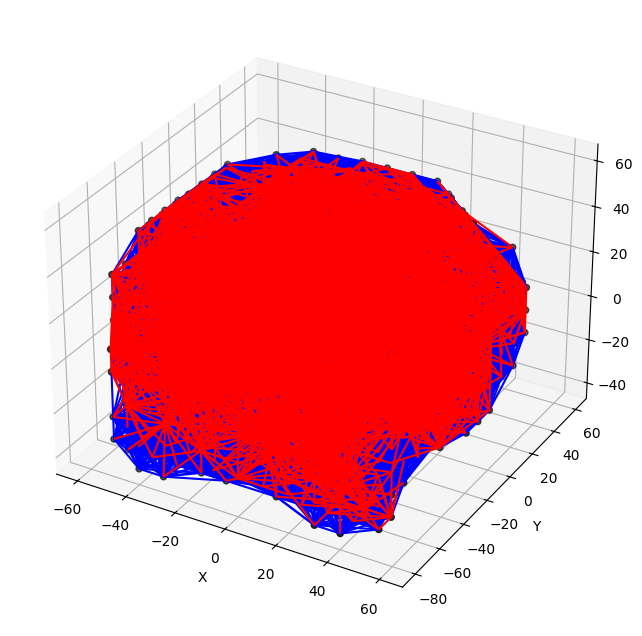

In [4]:
from neucube.visualise import spike_raster, plot_connections
res = Reservoir(inputs=X.shape[2], coordinates=brain_coordinates, mapping=eeg_mapping, swc=1, swr=0.15)
plot_connections(res)

Simulating data in SNNr...:   0%|          | 0/60 [00:00<?, ?it/s]

Simulating data in SNNr...: 100%|██████████| 60/60 [00:02<00:00, 24.86it/s]


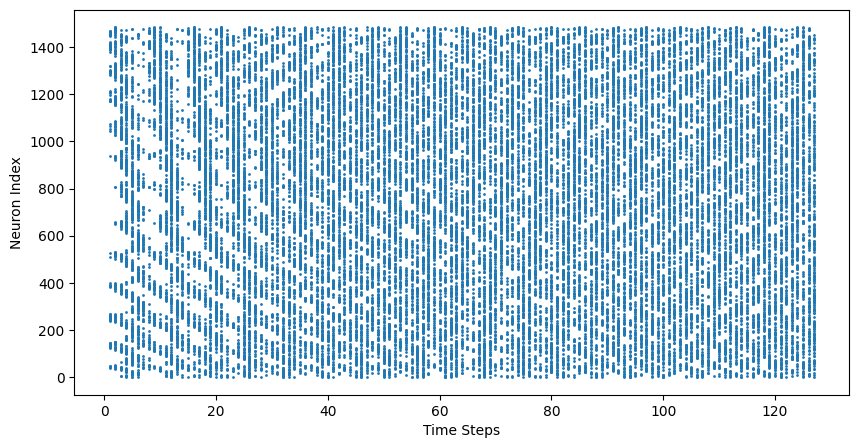

In [5]:
out = res.transform(X)
spike_raster(out[0])

Simulating data in SNNr...: 100%|██████████| 60/60 [00:02<00:00, 28.03it/s]


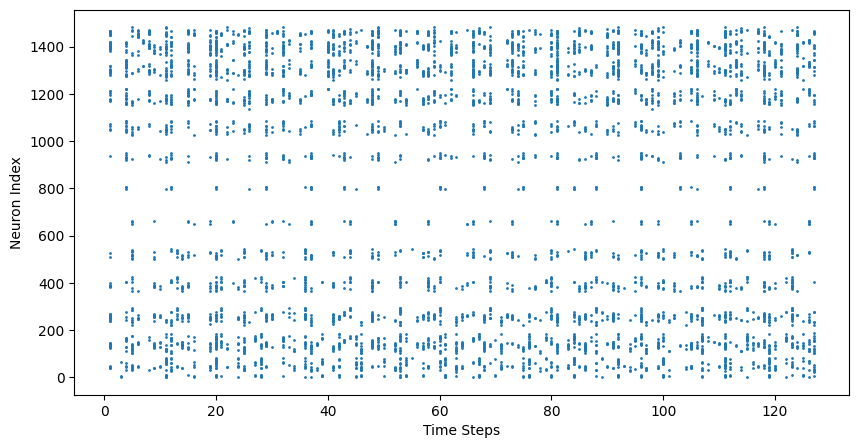

In [6]:
out = res.fit_transform(X)
spike_raster(out[0])

In [7]:
eeg_channels = {}
for i in range(len(feat_names)):
    eeg_channels[feat_names[i]] = np.array(eeg_mapping[i].to(device='cpu'))

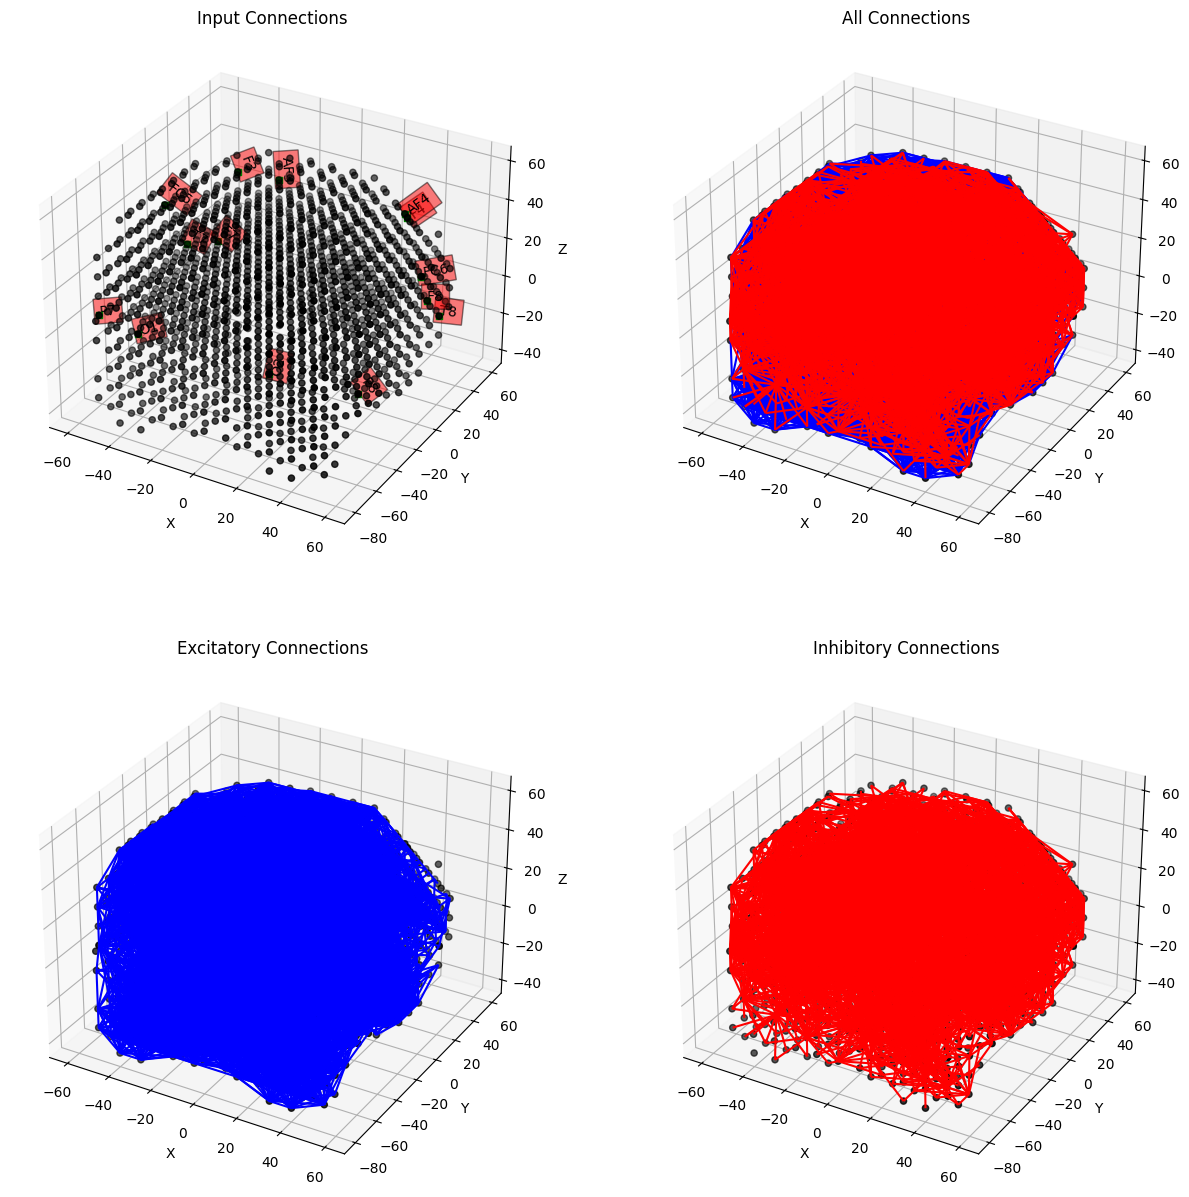

In [8]:
from neucube.visualise import plot_connections_detailed
plot_connections_detailed(res, eeg_coordinates=eeg_channels, fig_size=(15, 15))

In [11]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from neucube.training import STDP, STDPn

kf = KFold(n_splits=5, shuffle=True, random_state=123)
y_total, pred_total = [],[]
X = torch.tensor(fulldf.values.reshape(60,128,14))
encoder = Delta(0.8)
X = encoder.encode_dataset(X)
y = labels.values.flatten()

for train_index, test_index in tqdm(kf.split(X)):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  
  res = Reservoir(inputs=14, coordinates=brain_coordinates, mapping=eeg_mapping, refractory_period=5, mem_thr=0.1, swc=1, swr=0.15, learning_rule=STDP(0.0001, 0.01, 3))
  sam =  SpikeCount()
  clf = LogisticRegression(solver='liblinear')
  pipe = Pipeline(steps=
                  [
                    ("Res", res), 
                    ("Sam", sam), 
                    ("CLF", clf)
                  ])
  
  
  pipe.fit(X_train, y_train)
  pred = pipe.predict(X_test)

  y_total.extend(y_test)
  pred_total.extend(pred)

print(accuracy(y_total, pred_total))
print(confusion_matrix(y_total, pred_total))

Simulating data in SNNr...: 100%|██████████| 12/12 [00:00<00:00, 27.40it/s]
5it [00:27,  5.44s/it]

0.8333333333333334
[[17  2  1]
 [ 6 14  0]
 [ 0  1 19]]


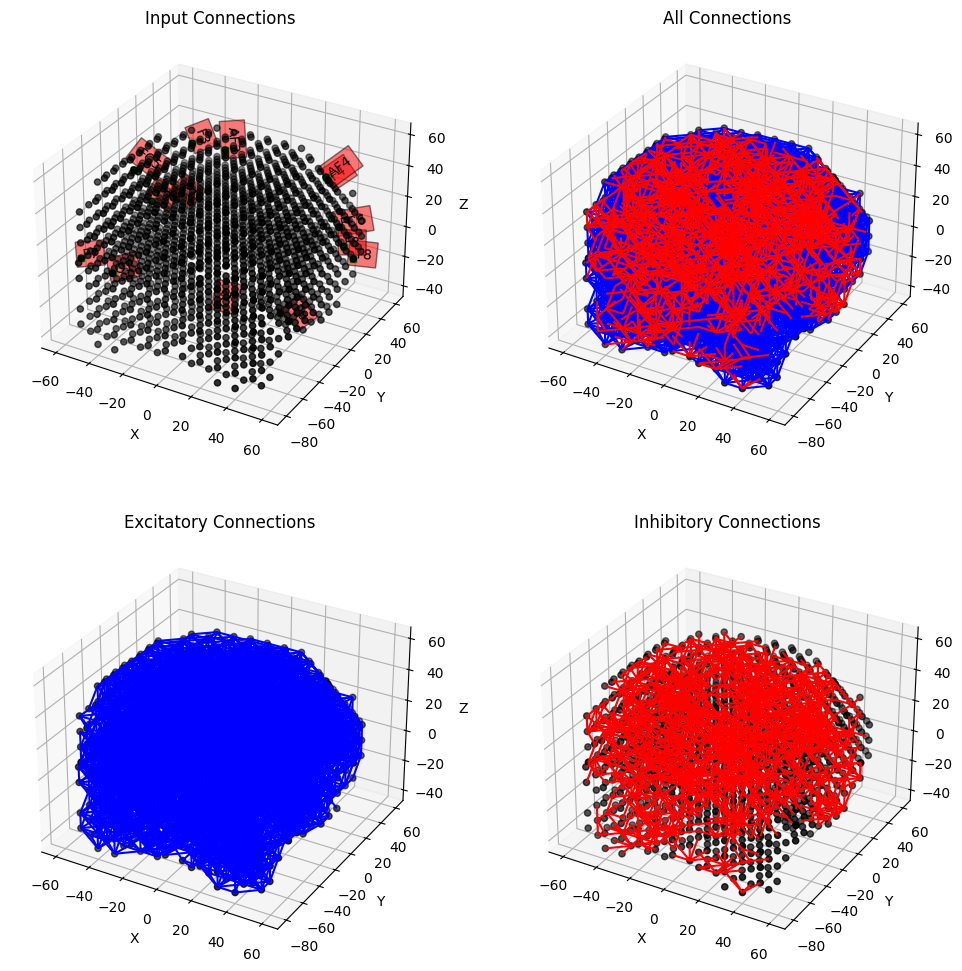

Fitting SNNr to input data...: 100%|██████████| 60/60 [00:03<00:00, 15.82it/s]


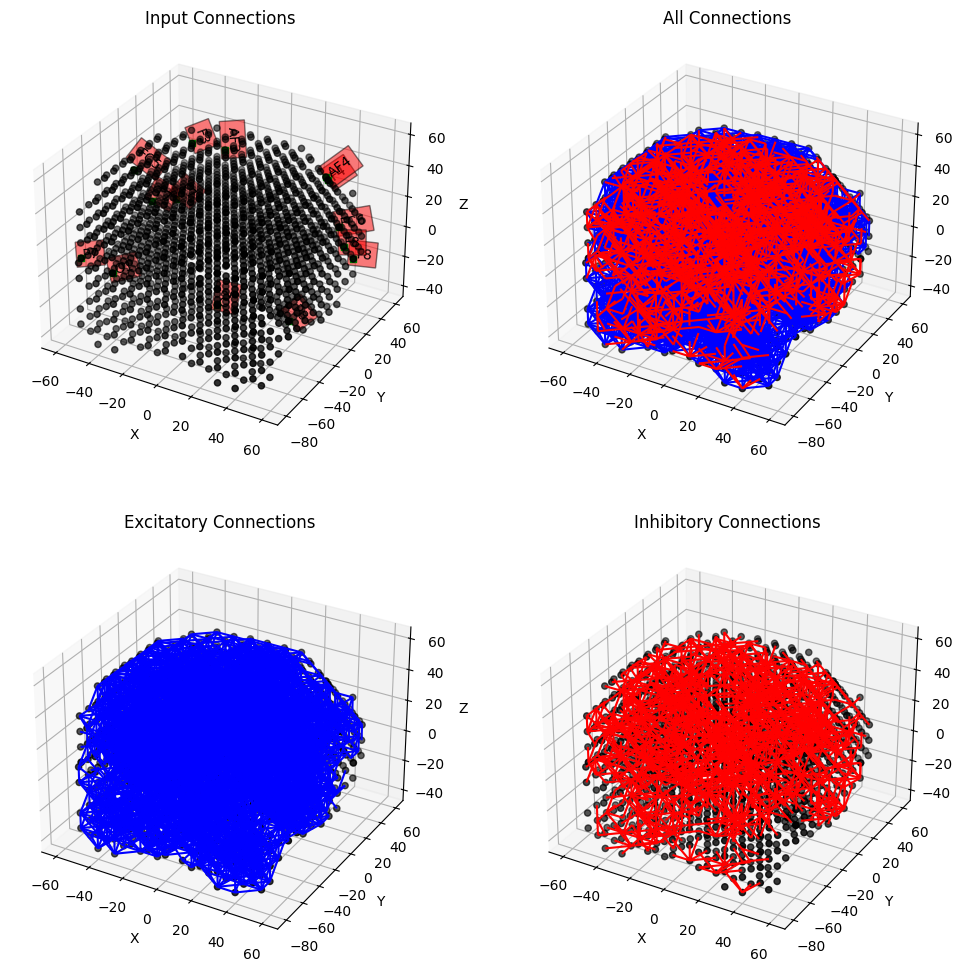

In [10]:
res = Reservoir(inputs=14, coordinates=brain_coordinates, mapping=eeg_mapping, swc=1, swr=0.1, learning_rule=STDP(0.0001, 0.01, 3))
plot_connections_detailed(res, eeg_coordinates=eeg_channels, fig_size=(12, 12))
res._fit(X)
plot_connections_detailed(res, eeg_coordinates=eeg_channels, fig_size=(12, 12))